In [1]:
#import jax.numpy as np
#from jax import pmap
import numpy as np
from maxnorm.maxnorm_completion import *
from maxnorm.tenalg import *
from maxnorm.graphs import *
import sparse
from itertools import product
import networkx as nx

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%load_ext autoreload

C:\Users\AARea\Documents\IMPORTANT DOCS\SCHOOL\Graduate\CSCI 692\max-qnorm-tensor-completion\maxnorm\maxnorm_completion.py:128: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if init is not 'alt_min':


In [2]:
# create random, low-rank tensor
t = 5
n = 30
r = 3
max_iterations = 100
epsilons = np.logspace(-4, -2, 3)
#delta = 0.1
const = 24
sigma = 0.005
ndata =  const * r * t * n * np.log10(n)
U = kr_random(n, t, r, rvs='unif')
U = kr_rescale(U, np.sqrt(n**t), 'hs')
norm_true = np.sqrt(kr_dot(U, U) / n**t)
#U = [np.random.randn(n, r) for i in range(t)]
print("n data: %.2e" % ndata)
print("n data ** t/2: %.2e" % int(const * r * n**(t/2) * np.log10(n)))
print("true norm: %.2e" % norm_true)

n data: 1.60e+04
n data ** t/2: 5.24e+05
true norm: 1.00e+00


In [3]:
qnorm_true = max_qnorm_ub(U)
print(qnorm_true)
print(r**(t/2))

55.921773193256264
15.588457268119896


In [4]:
expander = nx.random_regular_graph(6, n)
#expander = nx.chordal_cycle_graph(n)
observation_mask = obs_mask_expander(expander, t)
#observation_mask = obs_mask_iid(tuple([n for i in range(t)]), ndata * n**(-t))

In [5]:
from run_sweep_iid import generate_data


data = generate_data(observation_mask, U, sigma)
clean_data_rmse = np.sqrt(loss(U, data) / data.nnz)
print(data.nnz)
print(ndata)
print(n**t)
print("%0.1e%%" % (float(data.nnz) / n**t * 100))


38880
15952.909550972354
24300000
1.6e-01%


In [6]:
def print_factor_norms(U):
    print("fro:   " + str([np.linalg.norm(Ui,'fro')**2 for Ui in U]))
    print("2-inf: " + str([np.max(np.linalg.norm(Ui, axis=1)) for Ui in U]))

print_factor_norms(kr_balance_factors(U))

fro:   [71.65362804213422, 71.65362804213422, 71.65362804213422, 71.65362804213422, 71.65362804213419]
2-inf: [2.329868971460581, 2.3233257327676493, 2.075726201060879, 2.3160813731585885, 1.9983777626157493]


In [7]:
delta = 1.5 * sigma
#np.sqrt(np.sum((data.data - clean_data)**2)) * 2 / np.sqrt(data.nnz) * 1.5

print("rms of data:        %f" % clean_data_rmse)
print("delta parameter:    %f" % delta)
print("rmse of U true:     %f" % np.sqrt(loss(U, data) / data.nnz))

rms of data:        0.005015
delta parameter:    0.007500
rmse of U true:     0.005015


In [ ]:
%autoreload
Unew2_list = []
Unew1_list = []
cost_arr_list = []
cost_arr_list_min = []
ge_arr_list = []
ge_arr_list_min = []
ge_arr_mse_list = []
ge_arr_mse_list_min = []


delta = 0.1
iterations = 300
print(epsilons)
for eps in epsilons:
    print("eps = ", eps)
    Unew1, cost_arr1, ge_arr1, ge_mse_arr1 = tensor_completion_alt_min(U, data, 2 * r**t,
#                                             sgd=True, sgd_batch_size=2000,
                                            #U0 = Unew2,
                                            epsilon = eps,
                                            init='svdrand', 
                                            tol=1e-10, max_iter=iterations, verbosity=1)
    Unew1_list.append(Unew1)
    cost_arr_list_min.append(cost_arr1)
    ge_arr_list_min.append(ge_arr1)
    ge_arr_mse_list_min.append(ge_mse_arr1)
    
    Unew2, cost_arr2, ge_arr2, ge_mse_arr2 = tensor_completion_maxnorm(U, data, 4 * r**t, delta * np.sqrt(data.nnz), epsilon=eps,
#                                                 sgd=True, sgd_batch_size=2000,
                                                #U0 = kr_balance_factors(Unew1),
                                                init='svdrand',
                                                kappa=100, beta=1, 
                                                tol=1e-10, inner_tol=1e-12, max_iter=iterations, inner_max_iter=10, 
                                                verbosity=1, inner_line_iter=40,
                                                rebalance=True)
    Unew2_list.append(Unew2)
    cost_arr_list.append(cost_arr2)
    ge_arr_list.append(ge_arr2)
    ge_arr_mse_list.append(ge_mse_arr2)


[0.0001 0.001  0.01  ]
eps =  0.0001
Initial cost: 1.764e+04
Initial qnorm_ub: 1.797e+03
|| r || = 9.526e-01
Initial MSE : 1.000e+00


In [ ]:
for i in range(len(Unew2_list)):
    print("eps = {}".format(epsilons[i]))
    print("loss of U true:     %.3e" % np.sqrt(loss(U, data) / data.nnz))
    print("loss of U maxqnorm:      %.3e" % np.sqrt(loss(Unew2_list[i], data) / data.nnz))    
    print("loss of U altmin:      %.3e\n" % np.sqrt(loss(Unew1_list[i], data) / data.nnz))

Text(0.5, 1.0, 'GE-Curve for regularization terms')

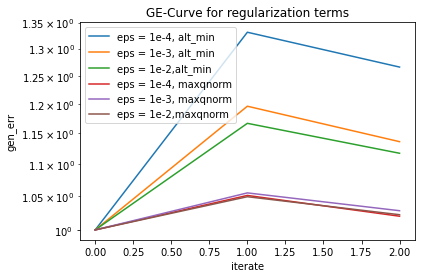

In [11]:
import matplotlib.pyplot as plt

plt.semilogy(ge_arr_list_min[0])
plt.semilogy(ge_arr_list_min[1])
plt.semilogy(ge_arr_list_min[2])
plt.semilogy(ge_arr_list[0])
plt.semilogy(ge_arr_list[1])
plt.semilogy(ge_arr_list[2])

plt.legend(["eps = 1e-4, alt_min", "eps = 1e-3, alt_min", "eps = 1e-2,alt_min", "eps = 1e-4, maxqnorm", "eps = 1e-3, maxqnorm", "eps = 1e-2,maxqnorm"])
plt.xlabel('iterate')
plt.ylabel('gen_err')
plt.title("GE-Curve for regularization terms")
plt.savefig('GE-Curve_epsilon.png')

Text(0.5, 1.0, 'Cost-Curve for maxqnorm regularization terms')

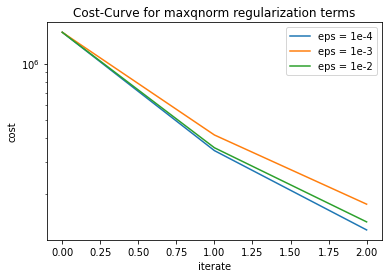

In [12]:
import matplotlib.pyplot as plt

plt.semilogy(cost_arr_list[0])
plt.semilogy(cost_arr_list[1])
plt.semilogy(cost_arr_list[2])

plt.legend(["eps = 1e-4", "eps = 1e-3", "eps = 1e-2"])
plt.xlabel('iterate')
plt.ylabel('cost')
plt.title("Cost-Curve for maxqnorm regularization terms")
# plt.savefig('Cost-Curve_epsilon_maxqnorm.png')

Text(0.5, 1.0, 'Cost-Curve for altmin regularization terms')

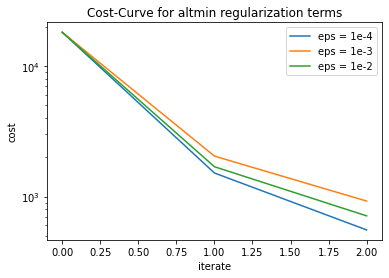

In [13]:
import matplotlib.pyplot as plt

plt.semilogy(cost_arr_list_min[0])
plt.semilogy(cost_arr_list_min[1])
plt.semilogy(cost_arr_list_min[2])

plt.legend(["eps = 1e-4", "eps = 1e-3", "eps = 1e-2"])
plt.xlabel('iterate')
plt.ylabel('cost')
plt.title("Cost-Curve for altmin regularization terms")
# plt.savefig('Cost-Curve_epsilon_altmin.png')

## Generalization error

In [35]:
# def gen_err(Upred, Utrue):
#     norm_true = kr_dot(Utrue, Utrue)
#     mse_gen = kr_dot(Upred, Upred) + norm_true - 2 * kr_dot(Upred, Utrue)
#     return np.sqrt(mse_gen / norm_true)

# def mse_gen_err(Upred, Utrue):
#     norm_true = kr_dot(Utrue, Utrue)
#     mse_gen = kr_dot(Upred, Upred) + norm_true - 2 * kr_dot(Upred, Utrue)
#     return np.sqrt(mse_gen / Upred[0].shape[0] ** len(Upred))


# for i in range(len(Unew2_list)):
#     print("eps = {}".format(epsilons[i]))
#     print("relative RMSE max:      %1.4e" % gen_err(Unew2_list[i], U))
#     print("MSE max:                %1.4e\n" % mse_gen_err(Unew2_list[i], U))

eps = 0.0
relative RMSE max:      2.8930e-02
MSE max:                2.8930e-02

eps = 0.0001
relative RMSE max:      2.8931e-02
MSE max:                2.8931e-02

eps = 0.001
relative RMSE max:      2.8940e-02
MSE max:                2.8940e-02

eps = 0.01
relative RMSE max:      2.9076e-02
MSE max:                2.9076e-02

eps = 0.1
relative RMSE max:      3.0496e-02
MSE max:                3.0496e-02

eps = 1.0
relative RMSE max:      3.6626e-02
MSE max:                3.6626e-02



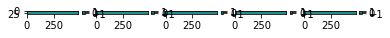

In [18]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# fig, axs = plt.subplots(1,t, figsize=(6, 20))
# # for i in range(t):
#     im = axs[i].imshow(Unew2[i])
#     divider = make_axes_locatable(axs[i])
#     cax = divider.append_axes('right', size='5%', pad=0.05)
#     fig.colorbar(im, cax=cax, orientation='vertical')
#     if i > 0:
#         axs[i].set_yticks([])

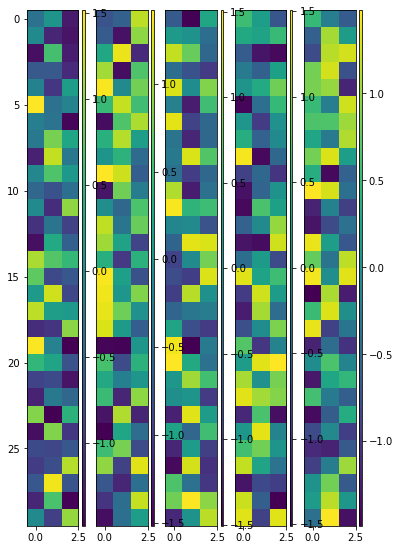

In [19]:
# from mpl_toolkits.axes_grid1 import make_axes_locatable

# fig, axs = plt.subplots(1,t, figsize=(6, 20))
# for i in range(t):
#     im = axs[i].imshow(U[i])
#     divider = make_axes_locatable(axs[i])
#     cax = divider.append_axes('right', size='5%', pad=0.05)
#     fig.colorbar(im, cax=cax, orientation='vertical')
#     if i > 0:
#         axs[i].set_yticks([])